## Convert a Custom Model for MNIST Dataset to ONNX and Inference with ONNX Runtime

This example performs a conversion of a 'hand-crafted' CNN for the MNIST dataset, loosely based on the lenet CNN. It creates a model in keras, evaluates it, converts it to ONNX format. Then, it loads the created ONNX file to perform predictions and compare it againt keras' predictions using ONNX Runtime.
Lastly, the model is converted into a TensorFlow framework

### Keras2Onnx
https://github.com/onnx/keras-onnx/blob/master/tutorial/TensorFlow_Keras_MNIST.ipynb

### Onnx2TF
https://github.com/onnx/onnx-tensorflow#installation


In [1]:
import sys
import os
import tensorflow as tf
print("TensorFlow version is "+tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Preparing MNIST Dataset

# Get MNIST dataset
mnist = tf.keras.datasets.mnist
# Load its data into training and test vectors
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
# Collect feature size info
imgSize0=len(x_train[0])
imgSize1=len(x_train[0][0])
numPixels=imgSize0*imgSize1
numTrainImages=len(x_train)
featureShape=(1,imgSize0,imgSize1)

print("Training dataset has "+str(numTrainImages))
print("Testing dataset has "+str(len(x_test)))
print("Feature shape is "+str(featureShape))

Training dataset has 60000
Testing dataset has 10000
Feature shape is (1, 28, 28)


In [3]:
# Check training and test label counts

# Training
train_labels_count = np.unique(y_train, return_counts=True)
# Testing
test_labels_count = np.unique(y_test, return_counts=True)

dataframe_labels = pd.DataFrame({'Label':train_labels_count[0], 'Train Count':train_labels_count[1], 'Test Count':test_labels_count[1]})
dataframe_labels

,Label,Train Count,Test Count
0,0,5923,980
1,1,6742,1135
2,2,5958,1032
3,3,6131,1010
4,4,5842,982
5,5,5421,892
6,6,5918,958
7,7,6265,1028
8,8,5851,974
9,9,5949,1009


## Building or Loading the CNN Model with Keras

If you are building a model in keras to convert it to ONNX, it's realy important that the first layer defines the input_shape, otherwise you will see errors in the ONNX conversion. See Issue #493 for more information.

In [4]:
# Clearup everything before running
tf.keras.backend.clear_session()

print ('creating a new model')
# Clearup everything before running
tf.keras.backend.clear_session()
# Create model
model = tf.keras.models.Sequential()
# Add layers
# The first layer MUST have input_shape. See the observation above.
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Build model and print summary
model.build(input_shape=featureShape)
model.summary()

creating a new model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


Training Model
Epoch 1/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5770 - accuracy: 0.8261
Epoch 2/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3167 - accuracy: 0.9085
Epoch 3/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2904 - accuracy: 0.9159
Epoch 4/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2761 - accuracy: 0.9198
Epoch 5/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2660 - accuracy: 0.9229
Epoch 6/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2588 - accuracy: 0.9250
Epoch 7/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2529 - accuracy: 0.9271
Epoch 8/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2470 - accuracy: 0.9280
Epoch 9/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2436 - accuracy: 0.9296
Epoch 10/15
1875/1875 [==============================] - 2s 1ms/ste

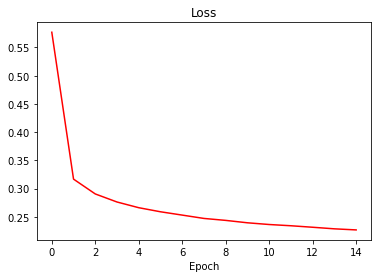

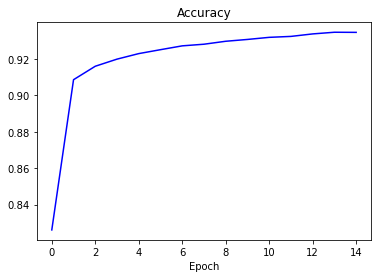

In [5]:
# Train model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training Model")
# NOTE: Increase the number of epochs if you wish better accuracy
history = model.fit(x_train, y_train, epochs=15)

# Loss plot
plt.plot(history.history["loss"], color='r')
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

# Accuracy plot
plt.plot(history.history["accuracy"], color='b')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Results
# Training time (15 epochs): ~1 min
# Initial Loss: 0.24
# Initial Accuracy: 0.93

In [6]:
# Evaluate Keras model performance
keras_test_loss, keras_test_acc = model.evaluate(x_test, y_test)

print('Test loss:', keras_test_loss)
print('Test accuracy:', keras_test_acc)

313/313 [==============================] - 0s 854us/step - loss: 0.2446 - accuracy: 0.9302
Test loss: 0.24463200569152832
Test accuracy: 0.9301999807357788


In [7]:
# If model was just created, update saved model
# Note: This is using an older model format
model.save('./mnist-model.h5')

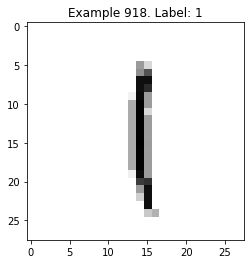

In [8]:
# Show random image via index from test set:
# Plotting data
image_index = int(np.random.randint(0, x_test.shape[0], size=1)[0])
expected_label = y_test[image_index]
digit_image = x_test[image_index]

# Plot
plt.title('Example %d. Label: %d' % (image_index, expected_label))
plt.imshow(digit_image, cmap='Greys')
plt.show()

In [9]:
# Reshape image for inference/prediction
digit_image = digit_image.reshape(1, imgSize0, imgSize1, 1)

# Repeat to take the average execution time
loop_count = 10

start_time = time.time()
for i in range(loop_count):
    prediction = model.predict(digit_image)
print("Keras inferences with %s second in average" %((time.time() - start_time) / loop_count))

print(prediction)
predicted_label = prediction.argmax()
print('Predicted value:', predicted_label)
if (expected_label == predicted_label):
  print('Correct prediction !')
else:
  print('Wrong prediction !')

Keras inferences with 0.05182957649230957 second in average
[[7.4264874e-09 9.8864871e-01 1.0398728e-03 2.9608659e-03 2.9196261e-05
  2.0817053e-03 2.4898452e-05 2.1233119e-03 2.9428450e-03 1.4865567e-04]]
Predicted value: 1
Correct prediction !


## Conversion from Keras to ONNX

Now we know that the keras model is working, we convert it to ONNX format and re-evaluate the model.

### Result Explanation:
1. Eager_mode: 
2. Converting Operators: 

In [10]:
import keras2onnx
print("keras2onnx version is "+keras2onnx.__version__)

# Convert to onnx model
onnx_model = keras2onnx.convert_keras(model, 'mnist-onnx', debug_mode=1)
output_model_path = "./mnist-model.onnx"

# Save the model in ONNX format
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense_1: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense_1/Identity:0
	input : dense/Identity:0
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Identity:0
	input : flatten/Identity:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Identity:0
	input : flatten_input:0
var: flatten_input
var: flatten_input:0
var: flatten_input:01
var: flatten/Identity:0
var: dense/Identity:0
var: dense_1/Identity:01
var: dense_1/Identity:0
var: dense_1
Converting the operator (Identity): Identity
Converting the operator (Identity1): Identity
Converting the operator (Identity2): Identity
Converting the operator (dense_1): <class 'tensorflow.python.keras.layers.core.Dense'>
Converting the operator (dense): <class 'tensorflow.python.keras.layers.core.Dense'>
Converting the operator (fl

keras2onnx version is 1.7.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________
None


The maximum opset needed by this model is only 11.


## Evaluating ONNX Model Performance (Against Keras Model)

1. Open ONNX Runtime session, providing model path...
2. Define data type to use (float32 is standard and has acceptable precision)
3. 

In [11]:
# Evaluate ONNX Model Performance
import onnxruntime

sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession(output_model_path, sess_options)
data = [digit_image.astype(np.float32)]
input_names = sess.get_inputs()
feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])

In [12]:
start_time = time.time()
for i in range(loop_count):
    onnx_predicted_label = sess.run(None, feed)[0].argmax()
print("ONNX inferences with %s second in average" %((time.time() - start_time) / loop_count))

print('ONNX predicted value:', onnx_predicted_label)
if (expected_label == onnx_predicted_label):
  print('Correct prediction!')
else:
  print('Wrong prediction!')

if (predicted_label == onnx_predicted_label):
  print("The ONNX's and keras' prediction are matching !")
else:
  print("The ONNX's and keras' prediction does not match !")

ONNX inferences with 0.0004008054733276367 second in average
ONNX predicted value: 1
Correct prediction!
The ONNX's and keras' prediction are matching !


## Converting ONNX Model to TensorFlow

1. Load ONNX model
2. Prepare TF representation of model
3. Export model into directory as a .pb file

Simple as that!

**Code Reference:**
https://github.com/onnx/onnx-tensorflow/blob/master/example/onnx_to_tf.py

In [16]:
import onnx
import warnings
from onnx_tf.backend import prepare

warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

# TODO: make a variable for saved model name

# Load model from current directory
onnx_model = onnx.load("mnist-model.onnx")

# Prepare tensorflow representation
#tf_rep = prepare(onnx_model)

# Export model to .pb format
#tf_rep.export_graph("mnist-model.pb")

In [14]:
# Print nodes of the model
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

NameError: name 'tf_rep' is not defined